# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [117]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

### First we look at the data, we use the .describe() to look at article_id column in the df and df_content data


##### Ref: https://www.geeksforgeeks.org/python-pandas-dataframe-describe-method/



In [118]:
# percentile list 
perc =[.20, .25,  .40, .50, .60, .75, .80] 
  
# list of dtypes to include 
include =['object', 'float', 'int'] 

df.article_id.describe( percentiles = perc, include = include)

count    45993.000000
mean       908.846477
std        486.647866
min          0.000000
20%        310.000000
25%        460.000000
40%        910.000000
50%       1151.000000
60%       1185.000000
75%       1336.000000
80%       1362.000000
max       1444.000000
Name: article_id, dtype: float64

### Similarly for df_content.article_id

In [119]:
df_content.article_id.describe(percentiles = perc, include = include)

count    1056.000000
mean      523.913826
std       303.480641
min         0.000000
20%       210.000000
25%       260.750000
40%       418.000000
50%       523.500000
60%       628.000000
75%       786.250000
80%       839.000000
max      1050.000000
Name: article_id, dtype: float64


#### Analysis

In the above cells, by looking at the results if describe, we can see that the article_ids of both data frames  do not match with each other, df data frame has article id range from 0 to 1444, where as  df_content range from 0 to 1444.

In [120]:
### we will use df data frame to look at the distribution of how many articles a user interacts with. In df data frame, each user has a email if, which they use
### to interact with the article. We can use email to find out the count of interactions per article. 

user_interact = df.groupby('email')['article_id'].count()
user_interact.sort_values(ascending = False).head()



email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

In [121]:
user_interact.describe(percentiles = perc, include = include)

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
20%         1.000000
25%         1.000000
40%         2.000000
50%         3.000000
60%         5.000000
75%         9.000000
80%        11.000000
max       364.000000
Name: article_id, dtype: float64

(0, 4000)

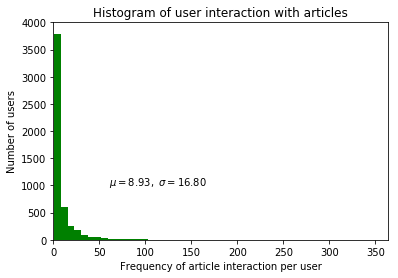

In [122]:
###Now we look at the visual representation
##Ref: https://matplotlib.org/3.1.1/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py
plt.hist(user_interact, bins = 50, color = 'g')
plt.xlabel("Frequency of article interaction per user")
plt.ylabel('Number of users')
plt.title('Histogram of user interaction with articles')
plt.text(60, 1000, r'$\mu=8.93,\ \sigma=16.80$')
plt.xlim(0, 364)
plt.ylim(0, 4000)



In [123]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with __3__ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ___364___.

print('50% of individuals interact with {} number of articles or fewer'.format(median_val))
print('The maximum number of user-article interactions by any 1 user is {}'.format(max_views_by_user))

50% of individuals interact with 3 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [124]:
# Find and explore duplicate articles

df_content[df_content.duplicated(subset = 'article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [125]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset = 'article_id', keep = 'first', inplace = True)

#check if there are any duplicates left. 
df_content[df_content.duplicated(subset = 'article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id


### Analysis:
As we can see there are no duplciates left

#### Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

#### a. The number of unique articles that have an interaction with a user.
#### c. The number of unique users in the dataset. (excluding null values)

##### Ref: https://www.geeksforgeeks.org/python-pandas-dataframe-nunique/


In [126]:
a1 = df.nunique(axis = 0)
a = a1['article_id']
c = a1['email']
print(a1)
print(a)
print(c)

article_id     714
title          714
email         5148
dtype: int64
714
5148


#### b. The number of unique articles in the dataset (whether they have any interactions or not).
#### d. The number of user-article interactions in the dataset.

##### Ref: https://www.geeksforgeeks.org/python-pandas-dataframe-nunique/

In [127]:
b1 = df_content.nunique(axis = 0)
b = b1['article_id']
d= df.shape[0]
print(b)
print(d)

1051
45993


In [128]:
unique_articles = a  # The number of unique articles that have at least one interaction
total_articles = b# The number of unique articles on the IBM platform
unique_users =  c# The number of unique users
user_article_interactions =  d# The number of user-article interactions


print('The number of unique articles that have at least one interaction are {}'.format(a))
print('The number of unique articles on the IBM platform are {}'.format(b))
print('The number of unique users are {}'.format(c))
print('The number of user-article interactions are {}'.format(d))

The number of unique articles that have at least one interaction are 714
The number of unique articles on the IBM platform are 1051
The number of unique users are 5148
The number of user-article interactions are 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [129]:
### Ref: https://stackoverflow.com/questions/48590268/pandas-get-the-most-frequent-values-of-a-column/48590361

df['article_id'].value_counts().idxmax()
df['article_id'].value_counts().max()

937

In [130]:
most_viewed_article_id =  df['article_id'].value_counts().idxmax().astype(str) # The most viewed article in the dataset as a string with one value following the decimal 
max_views =  df['article_id'].value_counts().max() # The most viewed article in the dataset was viewed how many times?

print('The most viewed article in the dataset as a string with {}'.format(most_viewed_article_id))
print('The most viewed article in the dataset was viewed {} times'.format(max_views))


The most viewed article in the dataset as a string with 1429.0
The most viewed article in the dataset was viewed 937 times


In [131]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [132]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [133]:
df['article_id'].value_counts().index[:5]


Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0], dtype='float64')

In [134]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    topn = df['article_id'].value_counts().index[:n]
    top_articles = list(df[df['article_id'].isin(topn)]['title'].unique())
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles=list(df['article_id'].value_counts().index[:n])
 
    return top_articles # Return the top article ids

In [135]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [136]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [137]:

##test
df2 = df.drop_duplicates(subset = ['user_id', 'article_id'])
df2.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [138]:
##test

user_item = df2.groupby(['user_id', 'article_id'])['title'].count().unstack()
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
##test

user_item.fillna(0, inplace = True)

user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df2 = df.drop_duplicates(subset = ['user_id', 'article_id'])
    user_item = df2.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item.fillna(0, inplace = True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)


###Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html

In [141]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [142]:
##test
ids = list(user_item.index)
print(ids)




[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [143]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    ##First we get the list of ids, that is to be used for similarity
    ids = list(user_item.index)
    user_item_row = np.array(user_item[user_item.index == user_id])
    # compute similarity of each user to the provided user
    dotx = np.dot(user_item_row, np.array(user_item).T)[0]
    dotx = pd.Series(dotx, index = ids)
    # sort by similarity
    dotx_sorted = dotx.sort_values(ascending = False)
   
    
    # remove the own user's id
    dotx_sorted.drop(labels = [user_id], inplace = True)
    # create list of just the ids
    most_similar_users = list(dotx_sorted.index)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [144]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [145]:
##test



In [146]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # First we start an empty list
    article_names = []
    ## we convert the article ids into float data type, just in case if they were a string
    article_ids  = list(map(float, article_ids))
    
    #getting a dataframe with respect to artilce ids
    df_article = df.drop_duplicates(subset = 'article_id')[['article_id', 'title']].set_index('article_id')
    article_name = list(df_article.loc[article_ids]['title'])
    
    #Now for loop
    for name in article_name:
        try:
            name = name.replace("\nName: title, dtype: object", "")
        except:
            continue
        article_names.append(name)
    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # first get a row for user defined in the function
    user_row = user_item.loc[user_id]
    # Now we get the index where we have interactions
    user_ind = np.where(user_row ==1)
    #Now artilce ids
    article_ids = list(user_row.index[user_ind])
    ##Now we use the function above to get the artilce names
    article_names = get_article_names (article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    #stat an empty list to store ids of recommended articles
    
    recs =[]
    
    #finding similar users to current users and articles viewed by current user and similar user
    sim_users =  find_similar_users(user_id)
    for i in sim_users:
        rec_ids, rec_names = get_user_articles(i)
        
        seen_ids, seen_names = get_user_articles(user_id)
        rec_articles  = np.setdiff1d(np.array(rec_ids), np.array(seen_ids), assume_unique = True)
        recs.extend(list(rec_articles))
        
        # if we have enough articles
        if len(recs) >= m:
            break
    
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    


##Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.setdiff1d.html

In [147]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [148]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [151]:
  ##First we get the list of ids, that is to be used for similarity
ids = list(user_item.index)
ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [193]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    ##First we get the list of ids, that is to be used for similarity--we copy it from above as we have used this before
    ids = list(user_item.index)
    user_item_row = np.array(user_item[user_item.index == user_id])
    # compute similarity of each user to the provided user
    dotx = np.dot(user_item_row, np.array(user_item).T)[0]
    dotx = pd.Series(dotx, index = ids)
    
    #Now we compute number of interactions which we have also computed above so we will just copy it from there
    user_inter_art = df.groupby('user_id')['article_id'].count()
    inter_count = user_inter_art.loc[ids]
    neighbors_df = pd.DataFrame({'neighbour_id': ids, 'similarity' :dotx,\
                                 'num_interactions':inter_count}).set_index('neighbour_id')
    #Now we remove current user as we have done before
    neighbors_df.drop([user_id], inplace = True)
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending = [False, False], \
                                                                           inplace = True)
    #Now we remove current user as we have done before

     

    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    #we have created a similar function above, following the same steps
    recs =[]
    
    #finding similar users to current users and articles viewed by current user and similar user
    top_users = get_top_sorted_users(user_id)
    topidx = top_users.index.values
    art_inter = df.groupby(['article_id'])['user_id'].count()
    
    
    ## we created a similar for loop before(i.e. above)
    for i in topidx:
        rec_ids, rec_names = get_user_articles(i)
        
        seen_ids, seen_names = get_user_articles(user_id)
        rec_articles = np.setdiff1d(np.array(rec_ids), np.array(seen_ids), assume_unique=True)
        sort_rec_articles = art_inter.loc[rec_articles].sort_values(ascending=False).index.values.tolist()
        recs.extend(sort_rec_articles)
        
              
        # if we have enough articles
        if len(recs) >= m:
            break
    
    # get only top m articles
    recs = recs[:m]
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [194]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


In [197]:
get_top_sorted_users(1).head()

,similarity,num_interactions
neighbour_id,,
3933,35.0,45
23,17.0,364
3782,17.0,363
203,15.0,160
4459,15.0,158


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [198]:
get_top_sorted_users(131).head(10)

,similarity,num_interactions
neighbour_id,,
3870,74.0,144
3782,39.0,363
23,38.0,364
203,33.0,160
4459,33.0,158
98,29.0,170
3764,29.0,169
49,29.0,147
3697,29.0,145


In [199]:
### Tests with a dictionary of results

user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [200]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here:**

#### Analysis:
Since we have no information about the new user, so collaborative filtering will not be the best option, as we will not be able to compare and match with other users and provide recommendations, however we can use top rated recommendations, and just recommend top rated articles to new users, which might not be the best option as well, as new user might have already read those artilces. I think to deal with such a problem, we should use FunkSVD

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [210]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(map(str,get_top_article_ids(10)))
# Your recommendations here



['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [211]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [212]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [213]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [214]:
# Perform SVD on the User-Item Matrix Here
## Ref: https://docs.scipy.org/doc/numpy/reference/routines.linalg.html
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)# use the built in to get the three matrices

In [215]:
u.shape, s.shape, vt.shape

((5149, 714), (714,), (714, 714))

**Provide your response here.**

#### Analysis: 
We can see that there are total of 5149 users, upto 714 latent features and 714 articles. Dimensions of all matrices are correct for dot product. 
Advantage of using FunkSVD which was proposed by Simon Funk is that we can use it to recommend  items to new users, even though we have no history/information about the new user.  It uses latent factor to recommend items to new users. This is beneficial as FunkSVD doesnt break down due to lack of data i.e. missing values. Because of this missing values, we use SVD to predict the rating the new user would give to the movie and then recommend the item to the new user accordingly. Funk SVD will ignore these missing values and find a way to compute latent factors only using the values we know. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

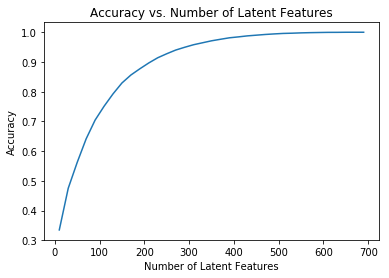

In [216]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [221]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)







In [225]:
train_idx = user_item_train.index.values
numtest = len(np.intersect1d(test_idx, train_idx))
numtest

20

In [227]:
numtest_null = len(test_idx) - numtest
numtest_null

662

In [228]:
train_arts = user_item_train.columns.values
numarts  = len(np.intersect1d(test_arts, train_arts))
numarts

574

In [229]:
numarts_null = len(test_arts) - numarts

numarts_null

0

In [231]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [232]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [233]:
# Now we find the subset of rows in user_item_Test 

u_test = u_train[user_item_train.index.isin(test_idx), :]
u_test.shape

(20, 714)

In [236]:
## Now we find the subset of vtrain inside the test_arts

vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

vt_test.shape

(714, 574)

In [249]:
pred = np.intersect1d(test_idx, train_idx)
user_test_sub = user_item_test[user_item_test.index.isin(pred)]
user_test_sub.shape

(20, 574)

In [253]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

from sklearn.metrics import accuracy_score

num_latent = np.arange(10,710,20)

train_acc = []
test_acc =[]

### We emulated from the class room and created new matrices for different number of latent features. As i changes, all matrices change accordingly


for i in num_latent:
    new_utrain, new_strain, new_vttrain = u_train[:,:i], np.diag(s_train[:i]), vt_train[:i,:]
    new_utest, new_vttest = u_test[:,:i], vt_test[:i,:]
    ###Dot product of matrices
    user_item_train_pred = np.around(np.dot(np.dot(new_utrain, new_strain), new_vttrain))
    user_item_test_pred = np.around(np.dot(np.dot(new_utest, new_strain), new_vttest))
    
    # clip predictions to 1 and 1 range
    # since we are only predicting whether user will interact with articles
    # which is a binary outcome
    user_item_train_pred = np.clip(user_item_train_pred, 0, 1)
    user_item_test_pred = np.clip(user_item_test_pred, 0, 1)
    
    # get accuracy score for this iteration
    acc_train = accuracy_score(np.array(user_item_train).flatten(), user_item_train_pred.flatten())
    acc_test = accuracy_score(np.array(user_test_sub).flatten(), user_item_test_pred.flatten())
    
    
    train_acc.append(acc_train)
    test_acc.append(acc_test)

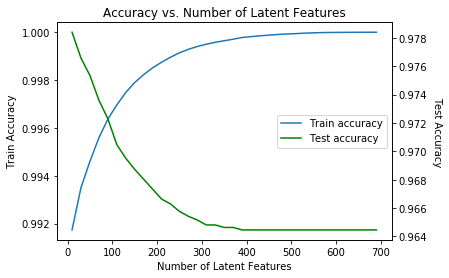

In [255]:
fig, ax1 = plt.subplots();
ax2 = ax1.twinx();

ax1.plot(num_latent, train_acc, label="Train accuracy");
ax2.plot(num_latent, test_acc, color='green', label="Test accuracy");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('Accuracy vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train Accuracy');
ax2.set_ylabel('Test Accuracy', rotation=270, labelpad=15);

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

#### Analysis:

As we have seen above that classes are highly imabalnced as there are lots of articles that user have no interacted with, as shown by the large proportion of class 0 as comapred to class 1. There might be some overfitting, as we have used 740 latent features, which makes the model complex and takes into account even small changes, however we can rectify that by making the model simpler and using less latent features. We can see above that the best accuracy of test, train sets can be achieved when we use approximately 100 latent features. If we use above, it leads to over fitting. 

Since we can only predict for 20 users, so above fitting might not be accurate representaiton for our prediction. A better metric will be the article recommendation and not article interaction. It could be that user never interacted with the article becuase they donot like the it, or may be user likes the articles but have no just interacted with it yet on the platform. 

We can also use A/B testing to see how our predictions are working. We can assign half users to control group and half to experimental group. 


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [256]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0